In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [30]:
raw_df = pd.read_csv("WSM_Merged_2018-01-24.csv")

In [31]:
raw_df.head()

,time,probeResp,rt,stimType,correct,logDelay,raw_index,baselineZMean,gazeXMean,gazeYMean,...,TP8-ALPHA,TP8-BETA,TP8-DELTA,TP8-SLOW,TP8-THETA,segmentNumber,artifact,estimated,participant_num,sart_seq
0,2017-06-23 11:14:40.516,0,536.0,nonTarget,1.0,130.0,235,0.227662,513.135523,392.117226,...,-1.654163,-0.682639,2.916505,0.206570,-0.852128,1,good,False,1,A
1,2017-06-23 11:14:46.167,0,461.0,nonTarget,1.0,134.0,407,0.579558,504.693087,396.596760,...,-0.045082,1.161409,-0.063867,-0.574339,0.801597,2,good,False,1,A
2,2017-06-23 11:14:51.811,0,677.0,nonTarget,1.0,130.0,578,1.200618,505.678603,397.208913,...,-0.238996,0.150115,-0.065244,0.521356,0.004024,3,good,False,1,A
3,2017-06-23 11:14:57.465,0,4952.0,target,1.0,138.0,749,0.200504,512.667357,394.897830,...,-1.498664,-0.421511,0.945570,0.452357,0.120957,4,good,False,1,A
4,2017-06-23 11:15:03.114,0,432.0,nonTarget,1.0,148.0,921,-0.420021,513.833807,381.688490,...,-0.473831,-0.555142,0.501546,-0.511868,1.354292,5,good,False,1,A


In [32]:
# Drop all eeg except for Fz
eeg_drop = [col for col in raw_df.columns.tolist() if "-" in col and "FZ" != col[0:2]]
raw_df.drop(eeg_drop, axis=1, inplace=True)

In [33]:
raw_df.columns.tolist()

['time',
 'probeResp',
 'rt',
 'stimType',
 'correct',
 'logDelay',
 'raw_index',
 'baselineZMean',
 'gazeXMean',
 'gazeYMean',
 'qualityPsize',
 'FZ-ALPHA',
 'FZ-BETA',
 'FZ-DELTA',
 'FZ-SLOW',
 'FZ-THETA',
 'segmentNumber',
 ' artifact',
 'estimated',
 'participant_num',
 'sart_seq']

In [34]:
# drop rows where markers were estimated
raw_df = raw_df.loc[~raw_df['estimated']]

# drop rows where eeg artifact is not good
raw_df = raw_df.loc[raw_df[' artifact'] == ' good']

# checkout the distribution for log delay
raw_df['logDelay'].quantile([.25,.5,.75,.8, .99])

0.25    130.0
0.50    139.0
0.75    149.0
0.80    151.0
0.99    163.0
Name: logDelay, dtype: float64

(array([   60.,   895.,  1752.,  1554.,  1055.,  1232.,  1012.,  1388.,
         1409.,   798.]),
 array([ 117. ,  121.2,  125.4,  129.6,  133.8,  138. ,  142.2,  146.4,
         150.6,  154.8,  159. ]),
 <a list of 10 Patch objects>)

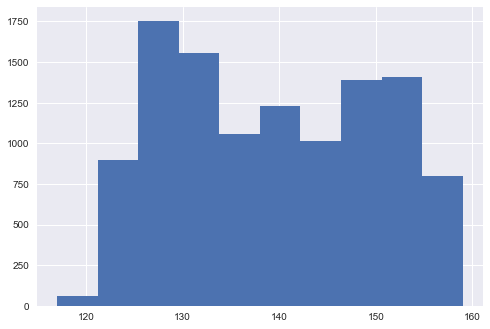

In [35]:
# drop log delay greater than 160
raw_df = raw_df.loc[raw_df['logDelay'] < 160]
plt.hist(raw_df['logDelay'])

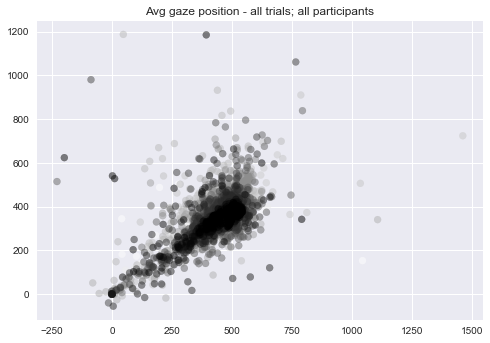

In [36]:
# checkout gaze position for each trial (for all participants)
plt.scatter(raw_df['gazeXMean'], raw_df['gazeYMean'], c=raw_df['participant_num'], alpha=.5)
plt.title("Avg gaze position - all trials; all participants")

In [37]:
# Curious if pupil size correlates with the quality score (before dropping trials)
raw_df.loc[:,['baselineZMean', 'qualityPsize']].corr()

,baselineZMean,qualityPsize
baselineZMean,1.000000,0.037437
qualityPsize,0.037437,1.000000


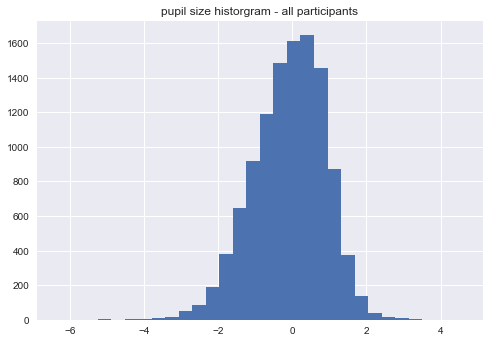

In [39]:
# check out pupil size distribution before dropping
plt.hist(raw_df['baselineZMean'], bins=30)
plt.title("pupil size historgram - all participants")

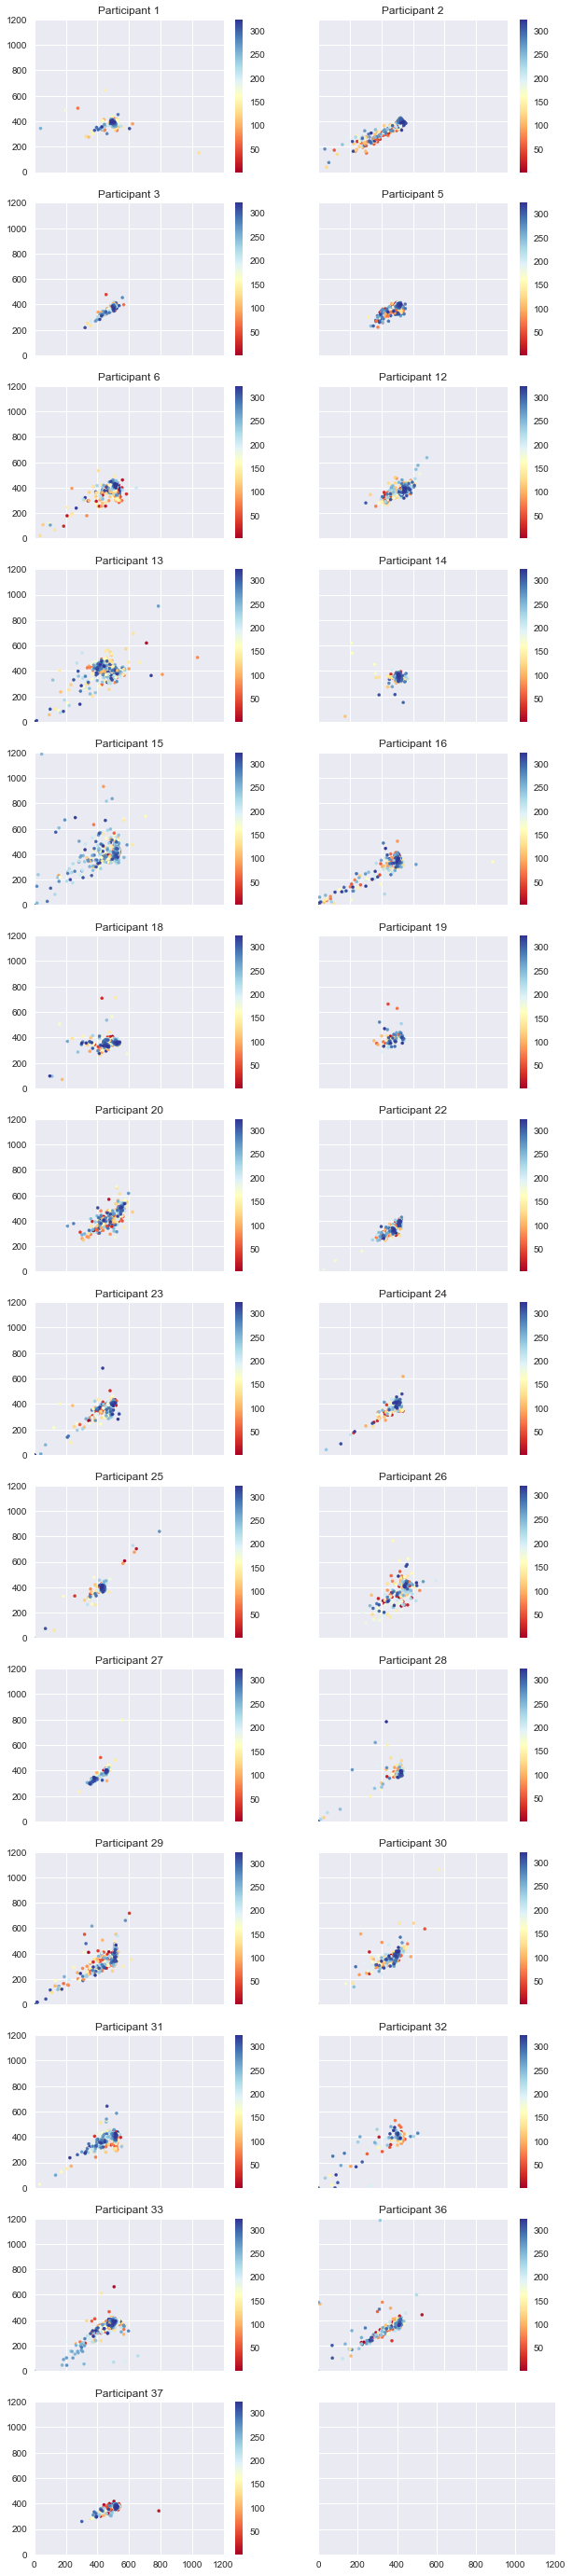

In [41]:
# Plot gaze position for each participant separately
# Color indicates trial number
# need to make this a function ...
n_cols = 2
n_rows = int(np.ceil(len(raw_df['participant_num'].unique()) / n_cols))

cm = plt.cm.get_cmap('RdYlBu')

f, axarr = plt.subplots(n_rows, n_cols, sharex='col', sharey='row', figsize=(10,50))

axi = 0
axj = 0

for pid in raw_df['participant_num'].unique():
    sc = axarr[axj, axi].scatter(raw_df.loc[raw_df['participant_num'] == pid, 'gazeXMean'], 
                            raw_df.loc[raw_df['participant_num'] == pid, 'gazeYMean'],
                            c=raw_df.loc[raw_df['participant_num'] == pid, 'segmentNumber'],
                            cmap=cm,
                            s=10)
    axarr[axj, axi].set_title("Participant {}".format(pid))
    axarr[axj, axi].set_xlim(0, 1200)
    axarr[axj, axi].set_ylim(0, 1200)
    f.colorbar(sc, ax=axarr[axj, axi])
    if axi < n_cols - 1:
        axi += 1
    else:
        axi = 0
        axj += 1
plt.show()

Note that color indicates the trial in figure. In the figure above, it makes sense that there is sort of a line from the origin to the center. Since these points are mean x and mean y, if there were any blinks or dropped frames, those would have values of 0, 0. But you would not expect points to deviate too far away from this line, and you wouldn't expect it to be PAST the center x or y point (which is think is (400, 500)). I will hold off on excluding trials based off of this data until I look at how well excluding bad trials for qualityPsize improves the data.

In [42]:
# Lets drop rows where more than 20% of the data was interpolated
raw_df = raw_df.loc[raw_df['qualityPsize'] >= 0.8]

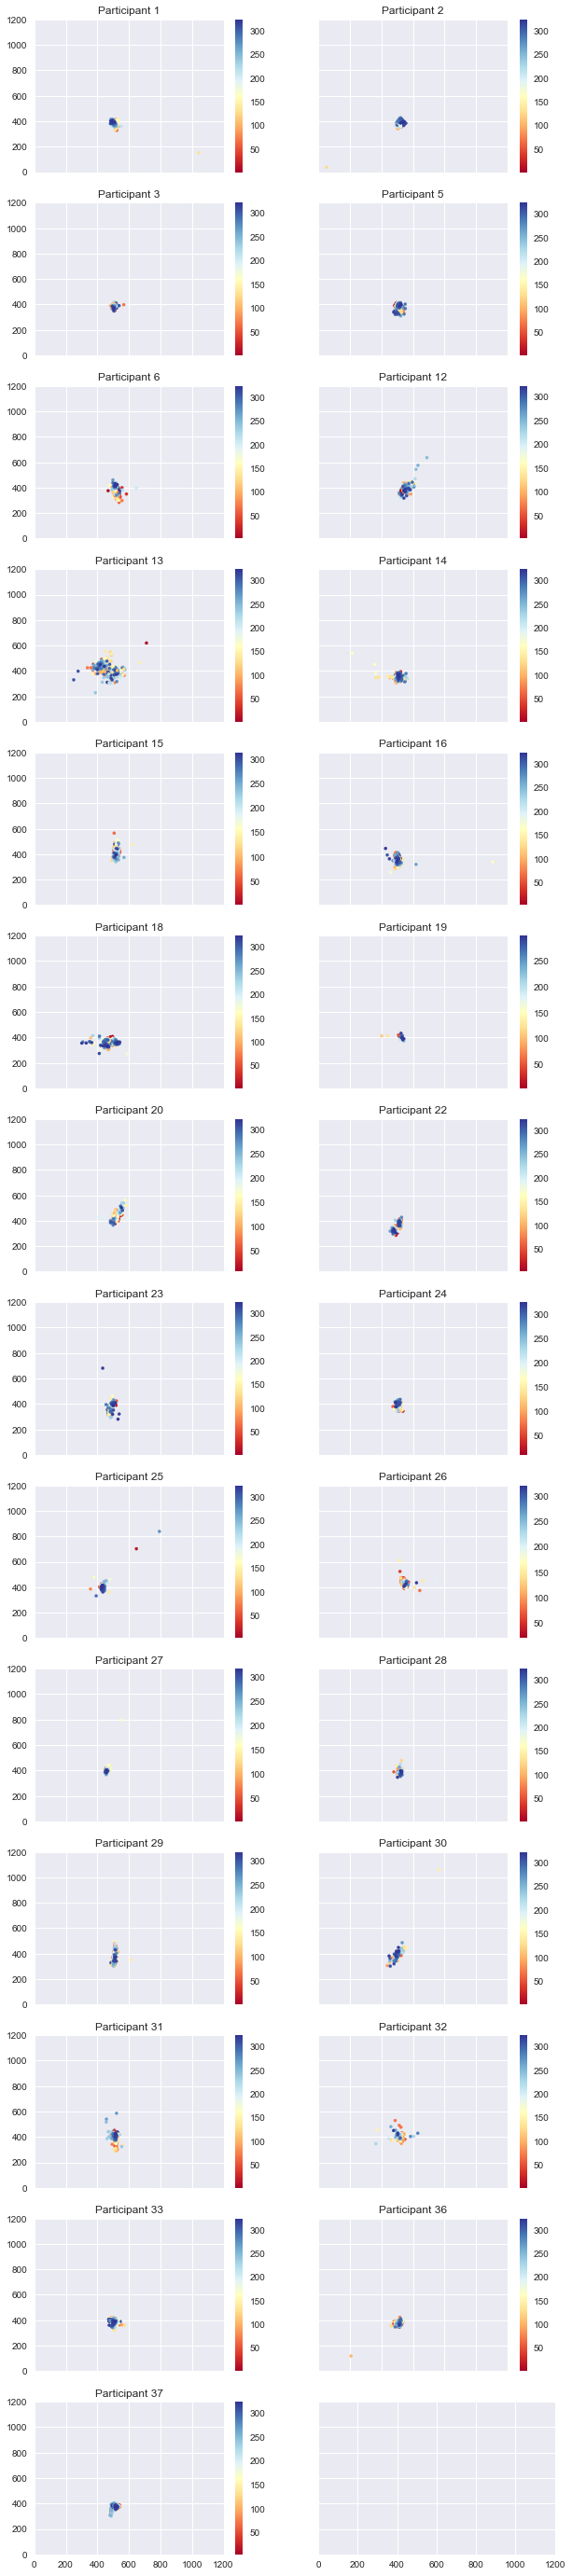

In [43]:
# now lets look at the gaze position plots again to see if they look better
n_cols = 2
n_rows = int(np.ceil(len(raw_df['participant_num'].unique()) / n_cols))

cm = plt.cm.get_cmap('RdYlBu')

f, axarr = plt.subplots(n_rows, n_cols, sharex='col', sharey='row', figsize=(10,50))

axi = 0
axj = 0

for pid in raw_df['participant_num'].unique():
    sc = axarr[axj, axi].scatter(raw_df.loc[raw_df['participant_num'] == pid, 'gazeXMean'], 
                            raw_df.loc[raw_df['participant_num'] == pid, 'gazeYMean'],
                            c=raw_df.loc[raw_df['participant_num'] == pid, 'segmentNumber'],
                            cmap=cm,
                            s=10)
    axarr[axj, axi].set_title("Participant {}".format(pid))
    axarr[axj, axi].set_xlim(0, 1200)
    axarr[axj, axi].set_ylim(0, 1200)
    f.colorbar(sc, ax=axarr[axj, axi])
    if axi < n_cols - 1:
        axi += 1
    else:
        axi = 0
        axj += 1
plt.show()

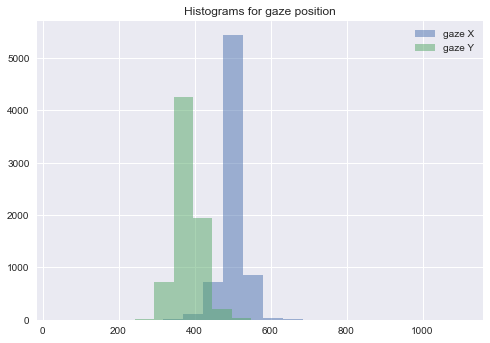

In [44]:
# That cleaned it up super well! It looks like there are still a few outliers though...
plt.hist(raw_df['gazeXMean'], alpha=.5, label="gaze X", bins=20)
plt.hist(raw_df['gazeYMean'], alpha=.5, label="gaze Y", bins=20)
plt.title("Histograms for gaze position")
plt.legend()

In [45]:
# get rid of rows where the x or y is not within 2 standard deviations
x_std = raw_df['gazeXMean'].std()
x_mean = raw_df['gazeXMean'].mean()
y_std = raw_df['gazeYMean'].std()
y_mean = raw_df['gazeYMean'].mean()

raw_df = raw_df.loc[raw_df['gazeXMean'].between(x_mean - x_std*2, x_mean + x_std*2)]
raw_df = raw_df.loc[raw_df['gazeYMean'].between(y_mean - y_std*2, y_mean + y_std*2)]

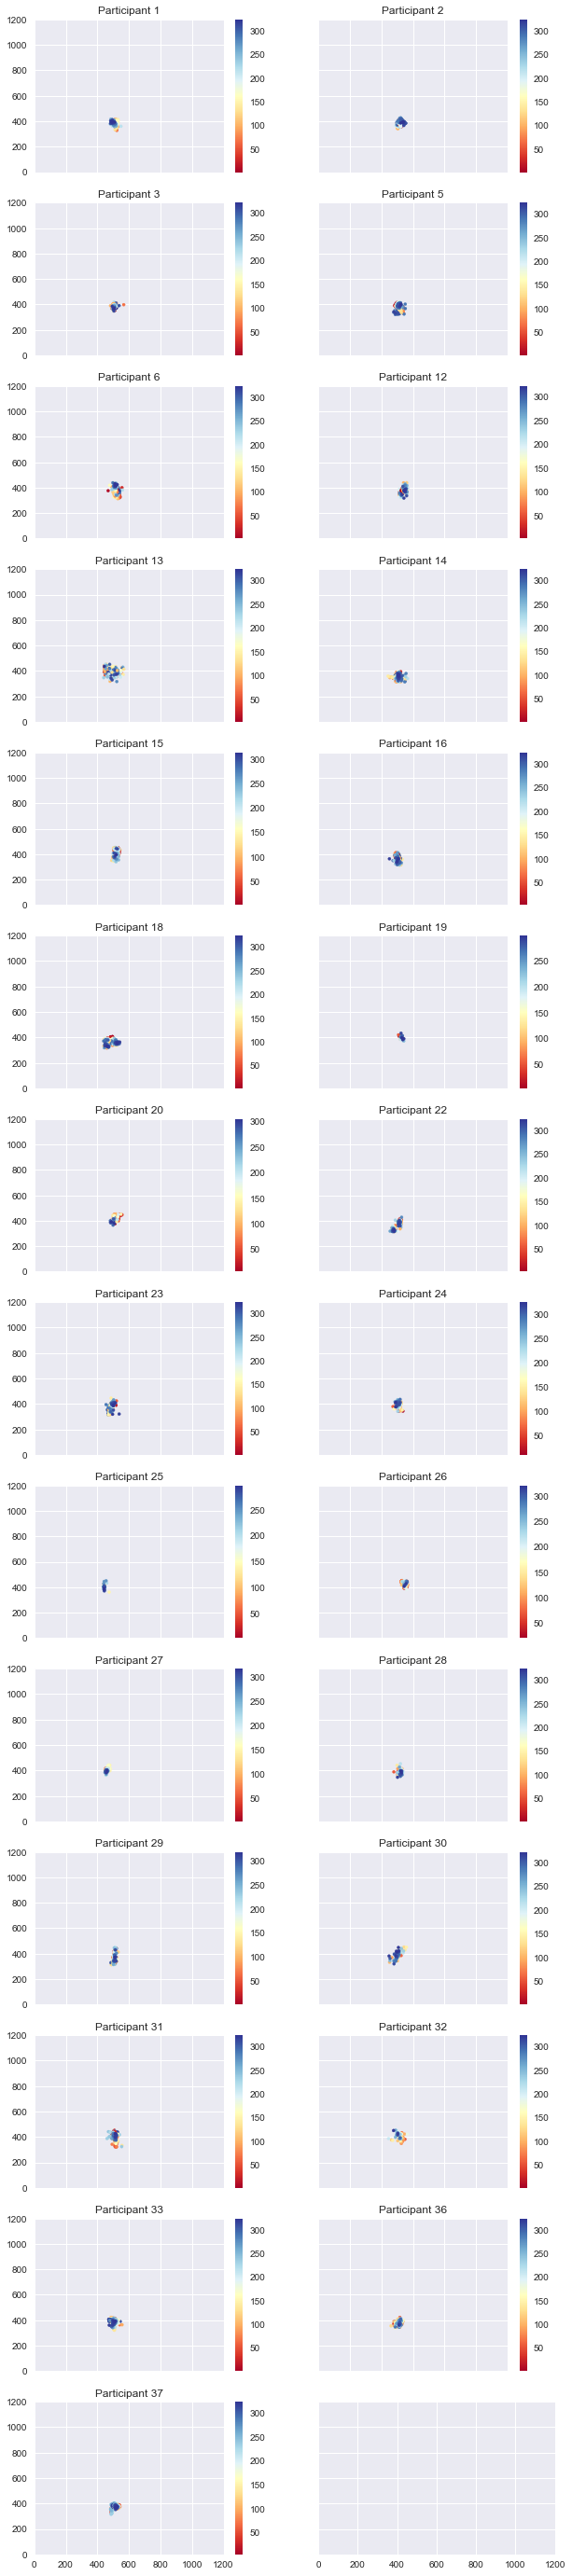

In [46]:
# checkout the gaze position plot again
n_cols = 2
n_rows = int(np.ceil(len(raw_df['participant_num'].unique()) / n_cols))

cm = plt.cm.get_cmap('RdYlBu')

f, axarr = plt.subplots(n_rows, n_cols, sharex='col', sharey='row', figsize=(10,50))

axi = 0
axj = 0

for pid in raw_df['participant_num'].unique():
    sc = axarr[axj, axi].scatter(raw_df.loc[raw_df['participant_num'] == pid, 'gazeXMean'], 
                            raw_df.loc[raw_df['participant_num'] == pid, 'gazeYMean'],
                            c=raw_df.loc[raw_df['participant_num'] == pid, 'segmentNumber'],
                            cmap=cm,
                            s=10)
    axarr[axj, axi].set_title("Participant {}".format(pid))
    axarr[axj, axi].set_xlim(0, 1200)
    axarr[axj, axi].set_ylim(0, 1200)
    f.colorbar(sc, ax=axarr[axj, axi])
    if axi < n_cols - 1:
        axi += 1
    else:
        axi = 0
        axj += 1
plt.show()

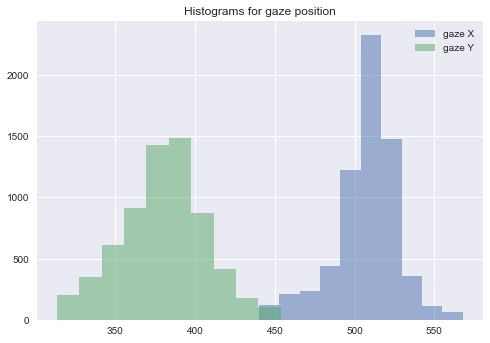

In [47]:
# Things should be very clean now, let's verify
plt.hist(raw_df['gazeXMean'], alpha=.5, label="gaze X")
plt.hist(raw_df['gazeYMean'], alpha=.5, label="gaze Y")
plt.title("Histograms for gaze position")
plt.legend()

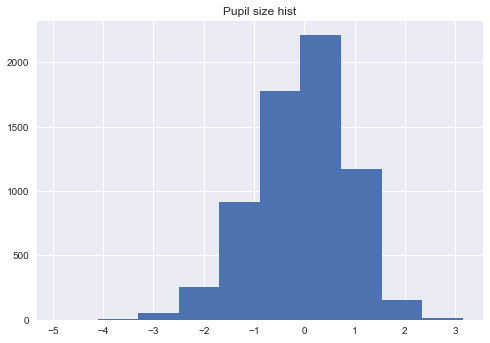

In [48]:
# checkout the pupil size distribution, now that we've cleaned things up
plt.hist(raw_df['baselineZMean'])
plt.title("Pupil size hist")

Maybe a little left skewed, but I guess thats ok. Could be due to a few reasons:
* maybe the bad trials had high zscores (which we dropped)
* actually that's all I can think of.

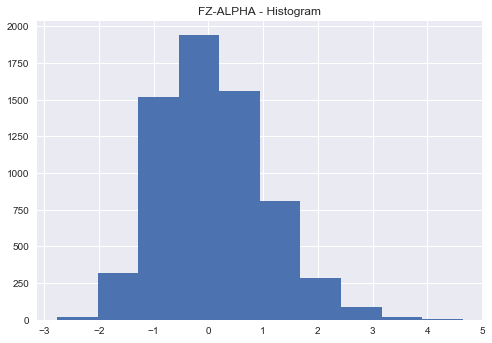

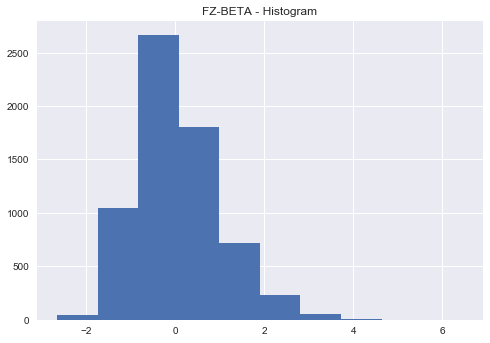

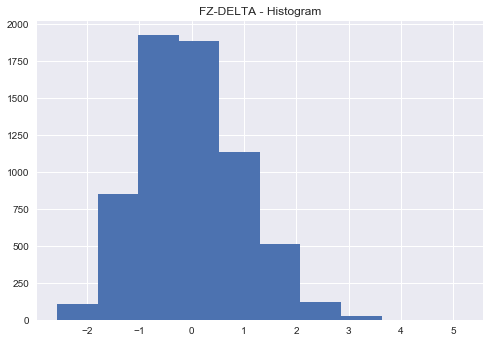

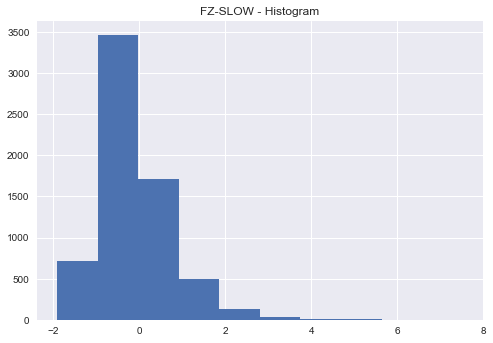

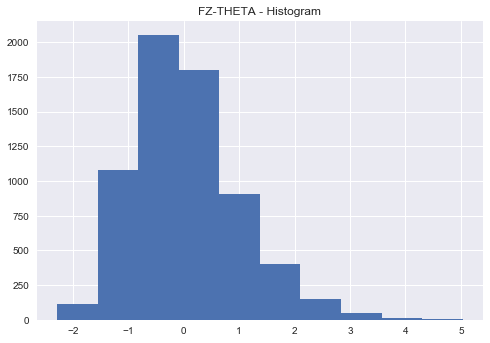

In [51]:
# checkout the eeg
fz_cols = ['FZ-ALPHA', 'FZ-BETA', 'FZ-DELTA', 'FZ-SLOW', 'FZ-THETA']
for eegcol in fz_cols:
    f = plt.figure()
    plt.hist(raw_df[eegcol])
    plt.title("{} - Histogram".format(eegcol))
    plt.show()

Again, kinda skewed for a few of them. Probably due to dropping eeg trials with bad artifact

In [52]:
# checkout the frequency of probe responses
raw_df['probeResp'].value_counts()

0    6040
2     220
5     108
4      94
1      77
3      27
Name: probeResp, dtype: int64

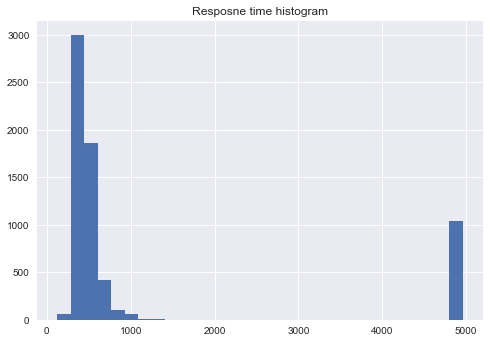

In [53]:
# checkout response time
plt.hist(raw_df['rt'], bins=30)
plt.title("Resposne time histogram")
plt.show()

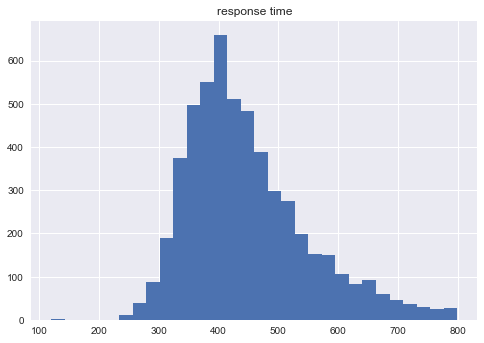

In [54]:
# Need to "get rid of" response time for rows where it was greater than 800
# - I'm just considering them all lapses
# replace them with nan's
raw_df.loc[raw_df['rt'] > 800, 'rt'] = np.nan
plt.hist(raw_df.loc[~raw_df['rt'].isnull(), 'rt'], bins=30)
plt.title("response time")

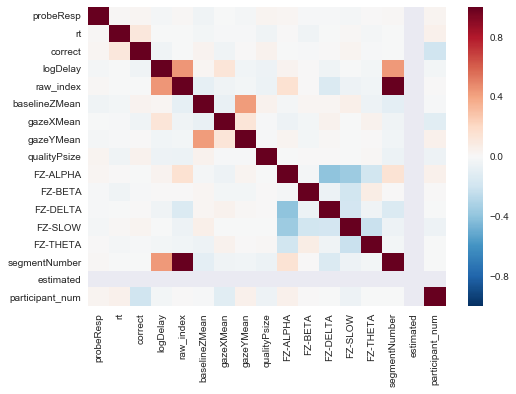

In [55]:
# Things should be pretty much cleaned up now. Let's look at heatmap of correlations
corr = raw_df.corr()
sns.heatmap(corr)

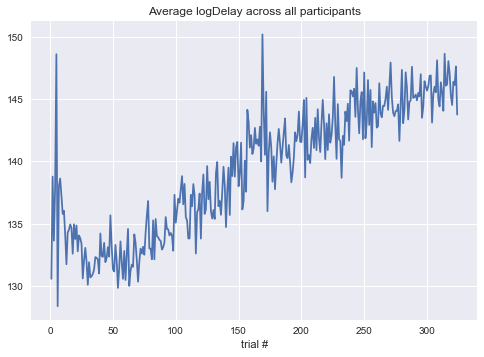

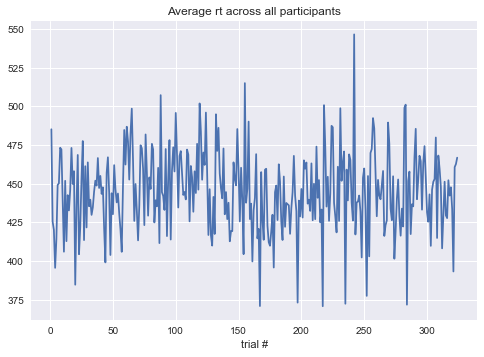

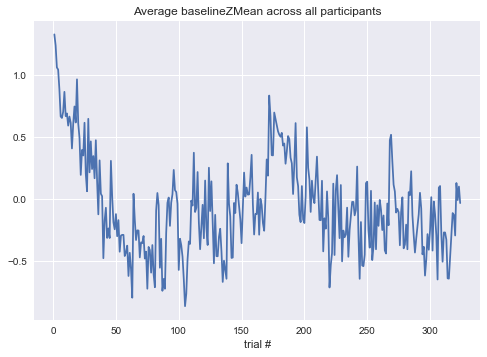

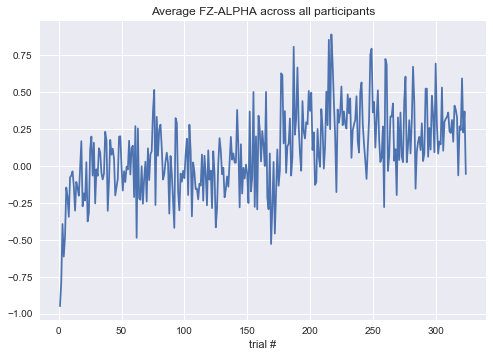

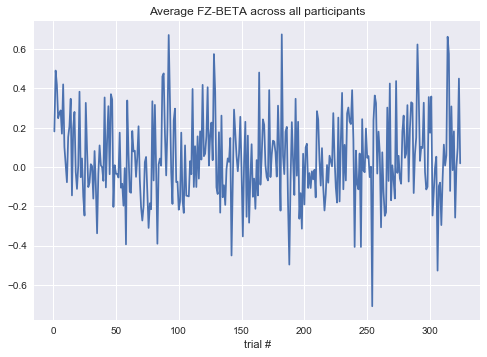

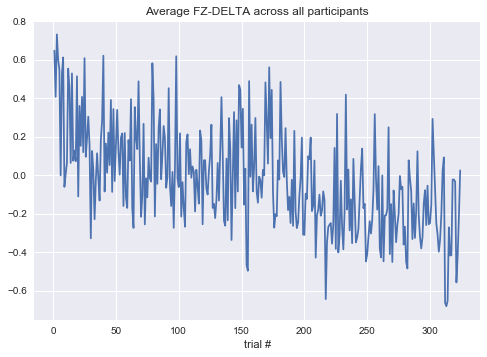

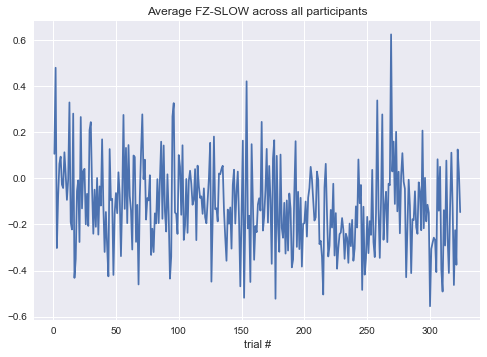

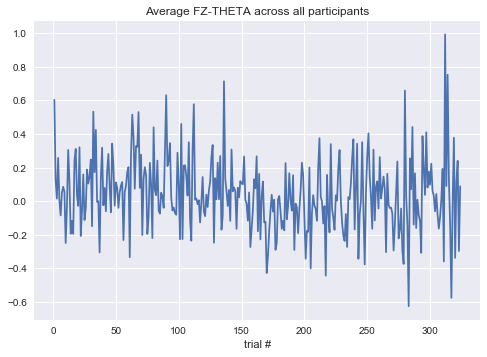

In [56]:
# Let's look at a time series for some variables
# Look at average value for each trial across all participants
avg_timeseries_cols = ['logDelay', 'rt', 'baselineZMean'] + fz_cols
for col in avg_timeseries_cols:
    f = plt.figure()
    plt.plot(raw_df.groupby(['segmentNumber'])[col].mean())
    plt.title("Average {} across all participants".format(col))
    plt.xlabel("trial #")
    plt.show()

You can tell where the break happened in some of the graphs (it happened around trial 175) - the pupil one is the most obvious, WHICH IS A PROBLEM. Could be due to a few things:
* light exposure during break (phone, light from hallway, etc)
* a breif spike due to having a mental break (replinished "arousal resources"??)
* z-scoring the halves separately - THIS is a problem (we didn't realize before). The second half of the task is being zscored with totally different values. So theoretically, if baseline pupil size was just continuing to decrease the entire time (the entire task), then splitting it up into two zscores creates a figure where it restarts at a highervalue at the beginning of the second section (like the beginning of the first section). We are going to go back and zscore them together.  

Its also pretty clear that pupil size, Alpha, and Delta show some effect from time.

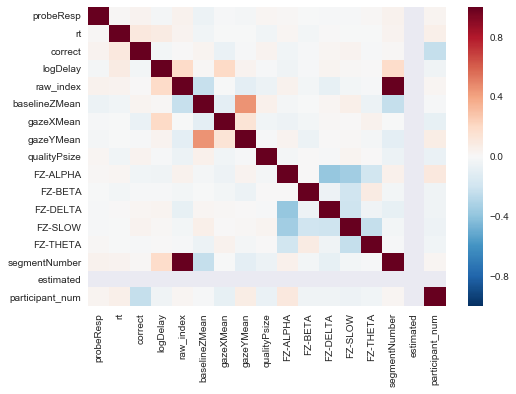

In [57]:
# just curious what the correlation matrix looks like when you
# only use data BEFORE the break (get rid of second half...)
first_half = raw_df.loc[raw_df['segmentNumber'] < 160]
corr = first_half.corr()
sns.heatmap(corr)

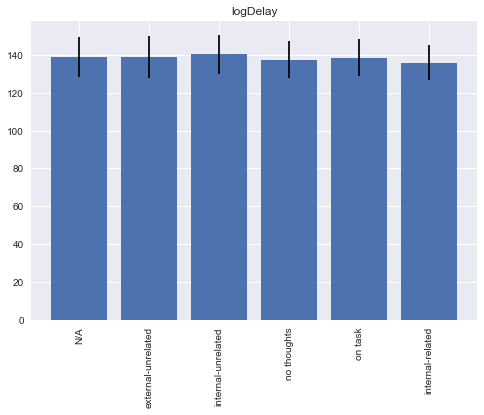

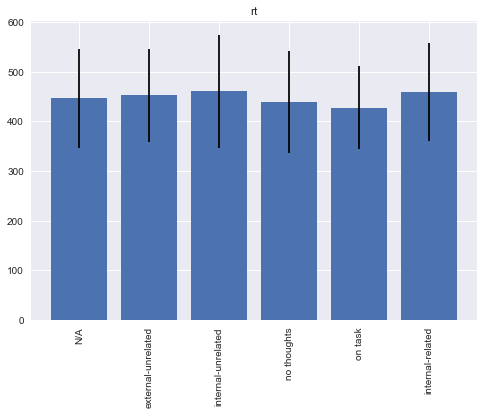

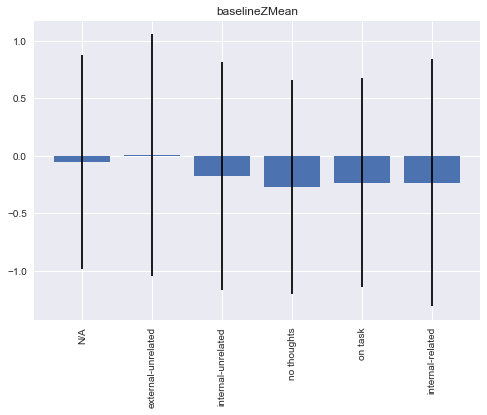

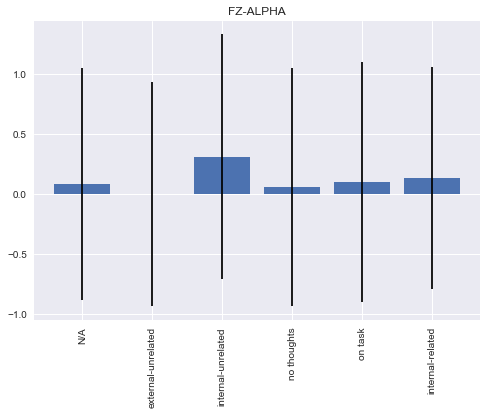

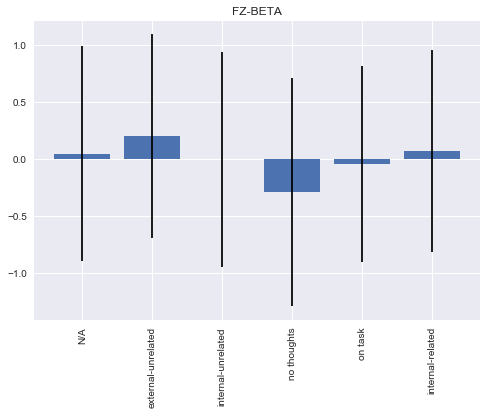

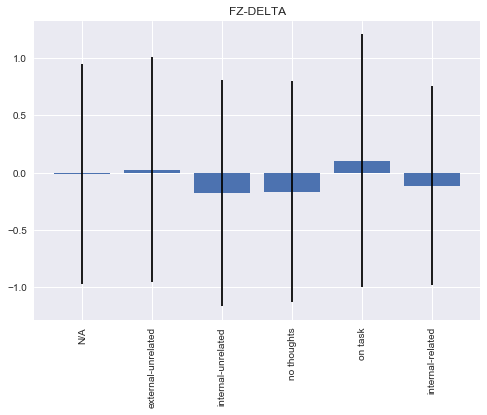

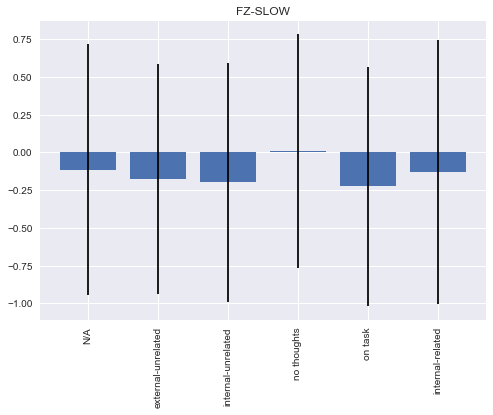

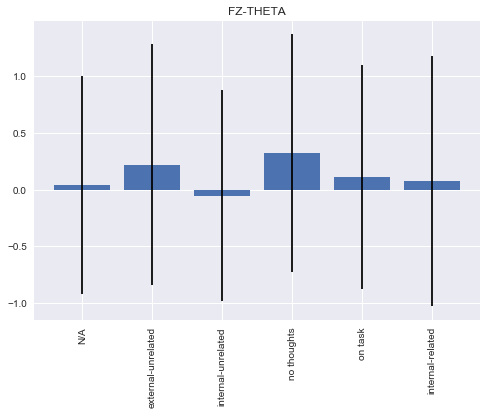

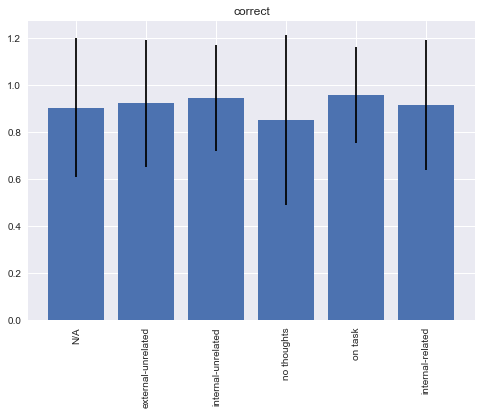

In [58]:
probe_resp_cols = avg_timeseries_cols + ['correct']
probeResp_df = raw_df.groupby(['probeResp'])

response_map = {
    4: 'on task',
    5: 'internal-related',
    1: 'external-unrelated',
    2: 'internal-unrelated',
    3: 'no thoughts',
    0: 'N/A'
}

for col in probe_resp_cols:
    f = plt.figure()
    plt.bar(np.arange(0,6), probeResp_df[col].mean(), yerr=probeResp_df[col].std())
    plt.title(col)
    plt.xticks(np.arange(0,6), [response_map[x] for x in np.arange(0,6)], rotation='vertical')
    plt.show()

In [59]:
raw_df['probeResp'].value_counts()

0    6040
2     220
5     108
4      94
1      77
3      27
Name: probeResp, dtype: int64

In [62]:
# checkout the probe response frequency for FAST response times...
raw_df.loc[raw_df['rt']<400].groupby('probeResp').size()

probeResp
0    1771
1      23
2      75
3       7
4      35
5      33
dtype: int64

Woah, for the response times that were pretty fast (less than 400 ms), the probe response 2 - internal unrelated - was the most frequent... that's interesting